# Mount dataset resources

In [1]:
import re
import pandas as pd
import numpy as np
import warnings

import datetime
from datetime import datetime, date
import time

# Visualisation
from matplotlib import pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# чтениие/запись файлов в feather-формате
import feather

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/github/eda_examples/Kaggle_Adult_income_dataset/'
%pwd

/content/drive/MyDrive/github/eda_examples/Kaggle_Adult_income_dataset


'/content/drive/MyDrive/github/eda_examples/Kaggle_Adult_income_dataset'

# Exploratory Data Analysis(EDA): An extensive guide

[Текст ссылки](https://inblog.in/Exploratory-Data-Analysis-EDA-An-extensive-guide-sgBSDstZR4)

Данная тетрадь включает следующие действия:
* Exploratory Data Analysis
* Missing Data and Outlier handling
* Feature Engineering and Feature Selection
* Model Building and Hyperparameter tuning techniques

We will be using the Xgboost algorithm to create our models.

## Why EDA?

Все мы знаем, что расширенный EDA является неотъемлемой частью жизненного цикла Data Science, но зачем нам это делать? Простой ответ на этот вопрос - лучше узнать наши данные и получить интуитивное понимание наших данных. Выполняя EDA, мы можем исследовать, в каких случаях наша модель дает верный прогноз, а в каких - нет, если вы рассматриваете проблему классификации. Кроме того, выводы, полученные из наших данных, могут быть использованы для согласования с тем, что говорят эксперты в предметной области, независимо от того, соответствуют ли данные их многолетнему опыту или нет.


## Our problem

В нашем случае мы будем использовать набор данных о доходах взрослого населения, который можно использовать для прогнозирования того, имеет ли человек доход выше 50 тысяч долларов США или нет, на основе ряда переменных. Таким образом, мы имеем дело с проблемой машинного обучения классификации с учителем.


In [4]:
# Importing the required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [5]:
# Importing the required datasets:
# https://www.kaggle.com/wenruliu/adult-income-dataset

adi_data = pd.read_csv('adult.csv')

## Descriptive analysis

### 1.1. Common view of the dataset (head & tail)

In [6]:
# In order to get a feel for our data, we will take a look at the head and tail columns

# Checking the head and tail columns for the train data:
adi_data.head(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [7]:
# tail columns

adi_data.tail(5)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
48841,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


**Observations:**
* Мы можем заметить, что у нас есть числовые, а также категориальные переменные для данных.
* Мы можем заметить, что есть некоторые недостающие данные, также обозначенные знаком «?», Мы заменим их значениями 'nan'.


### 1.2. Shape & info

In [18]:
# Now we will check the shape of the datasets:
print(f'The shape of the data: {adi_data.shape}')

# Taking a look at the variable types:
print(f'\nDataset info:')
adi_data.info()

The shape of the data: (48842, 15)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [19]:
# Using the describe we will try and gain more insights of our data:
adi_data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


**Observations:**
* В данных есть как числовые тка и категориальные переменные.

Прежде чем проводить дальнейший анализ, мы разделим данные на числовые и категориальные, чтобы упростить наш анализ.


## Numerical & Categorical features

* numeric_data - числовые фичи
* categorical_data - категорийные фичи


In [ ]:
# NUMERIC FEATURES:

numeric_data = adi_data.select_dtypes(include=np.number) # select_dtypes selects data with numeric features
numeric_col = numeric_data.columns 

print('Numeric Features: ')
print(numeric_data.head(5))
print('----'*20)

Numeric Features: 
   age  fnlwgt  educational-num  capital-gain  capital-loss  hours-per-week
0   25  226802                7             0             0              40
1   38   89814                9             0             0              50
2   28  336951               12             0             0              40
3   44  160323               10          7688             0              40
4   18  103497               10             0             0              30
--------------------------------------------------------------------------------


In [ ]:
# CATEGORICAL FEATURES:

categorical_data = adi_data.select_dtypes(exclude=np.number) # we will exclude data with numeric features
categorical_col = categorical_data.columns

print('Categorical Features: ')
print(categorical_data.head(5))
print('----'*20)

Categorical Features: 
   workclass     education      marital-status  ...  gender native-country income
0    Private          11th       Never-married  ...    Male  United-States  <=50K
1    Private       HS-grad  Married-civ-spouse  ...    Male  United-States  <=50K
2  Local-gov    Assoc-acdm  Married-civ-spouse  ...    Male  United-States   >50K
3    Private  Some-college  Married-civ-spouse  ...    Male  United-States   >50K
4          ?  Some-college       Never-married  ...  Female  United-States  <=50K

[5 rows x 9 columns]
--------------------------------------------------------------------------------


## CHECKING MISSING DATA:

In [ ]:
# We will check the missing values for the train as well as the test data.

na_values = (adi_data.isnull().sum()/adi_data.isnull().count())
na_values

# We are getting 0 na values but that is not possible as we have seen ? in our dataset.
# We will replace ? with np.nan to get our na values.

age                0.0
workclass          0.0
fnlwgt             0.0
education          0.0
educational-num    0.0
marital-status     0.0
occupation         0.0
relationship       0.0
race               0.0
gender             0.0
capital-gain       0.0
capital-loss       0.0
hours-per-week     0.0
native-country     0.0
income             0.0
dtype: float64

In [ ]:
# We have observed that we have special characters in the dataset.
# Checking how many rows and variables have special characters.

adi_data.isin(['?']).sum(axis=0)

# We can observe that workclass, occupation and native-country have special characters.

age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

In [ ]:
# replacing the ? value with np.nan value for the 3 columns:

# train data:
adi_data['workclass'] = adi_data['workclass'].replace('?', np.nan)
adi_data['occupation'] = adi_data['occupation'].replace('?', np.nan)
adi_data['native-country'] = adi_data['native-country'].replace('?', np.nan)


In [ ]:
# Checking if the special characters have been replaced by Nan

adi_data.head(10)
# ? values have been replaced with NaN.

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,NaN,227026,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [ ]:
# The rows with NaN values is not much, we will drop the data with NaN values.

#dropping the NaN rows now 
adi_data.dropna(how='any',inplace=True)

In [ ]:
# Checking the shape of the data:
adi_data.shape

(45222, 15)

In [ ]:
# assigning adi_data to adi_data_v1

adi_data_v1 = adi_data

## CHECKING OUTLIERS:

В этой части мы проверим, присутствуют ли какие-либо выбросы в числовых столбцах.

Мы будем рассматривать точки за пределами `third quartile + 1.5*IQR` и точки ниже `first quartile - 1.5*IQR` как **выбросы**.


In [ ]:
cols = list(numeric_data) # A List of all features

outliers = pd.DataFrame(columns=['Feature','Number of Outliers']) # Creating a new dataframe to

for column in numeric_col: # Iterating thorough each feature            
            # first quartile (Q1)
        q1 = numeric_data[column].quantile(0.25) 
            
            # third quartile (Q3)
        q3 = numeric_data[column].quantile(0.75)
            
            # IQR
        iqr = q3 - q1
            # 
        fence_low = q1 - (1.5*iqr)
        
        fence_high = q3 + (1.5*iqr)
            # finding the number of outliers using 'and(|) condition. 
        total_outlier = numeric_data[(numeric_data[column] < fence_low) | (numeric_data[column] > fence_high)].shape[0]
        
        outliers = outliers.append({'Feature':column,'Number of Outliers':total_outlier},ignore_index=True)
outliers

,Feature,Number of Outliers
0,age,216
1,fnlwgt,1453
2,educational-num,1794
3,capital-gain,4035
4,capital-loss,2282
5,hours-per-week,13496


**Observations from NA values and Outlier inspection.**

* Для некоторых из наших признаков есть значения na, но, поскольку значения малы по сравнению с размером набора данных, мы удалили значения na.
* Выбросы присутствуют почти во всех числовых переменных наших данных.
* Мы продолжим изучать наши данные, а затем решим, как обрабатывать эти выбросы.


## IN-DEPTH EDA AND DATA VISUALIZATION:

**UNIVARIATE ANALYSIS:**<br>
В этом разделе мы проведем одномерный (univariate) анализ наших числовых, а также категориальных переменных.

**NUMERIC DATA:**<br>
Мы построим гистограммы для числовых данных и проверим распределения для каждой переменной.


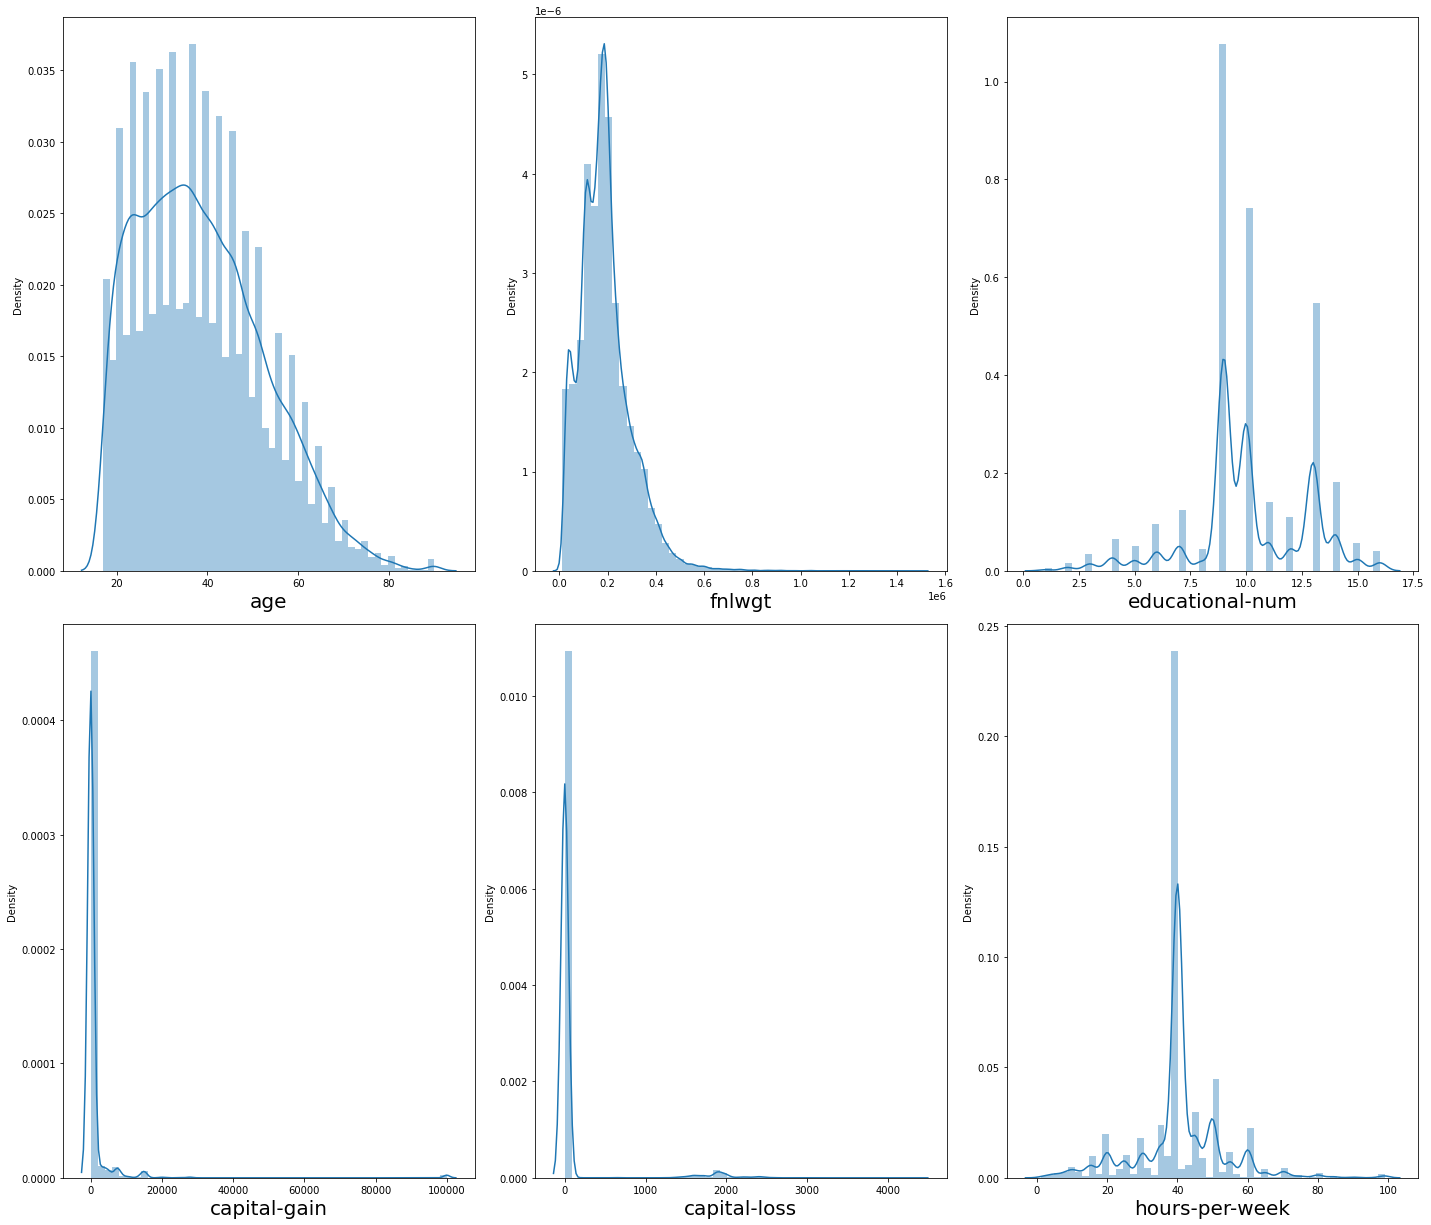

In [ ]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in numeric_data:
    if plotnumber<=16 :
        ax = plt.subplot(3,3,plotnumber)
        sns.distplot(numeric_data[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.tight_layout()

**Observations:**

* Просто наблюдая за числовыми переменными age, fnlwgt, hrs per week and educational, мы можем сказать, что в данных есть довольно большие вариации.
* Рассматривая переменныеcapital gain and capital loss, мы видим, что они имеют меньшую дисперсию, так как большинство значений равны 0. Мы могли бы также пропустить эти переменные.
* Age переменная не сильно искажена, но остальные переменные либо искажены, либо распределены неравномерно.
* Глядя на распределения, мы можем решить, что делать с нашими выбросами.


## CATEGORICAL DATA:
We will plot the barplots for the each of the categorical variables.

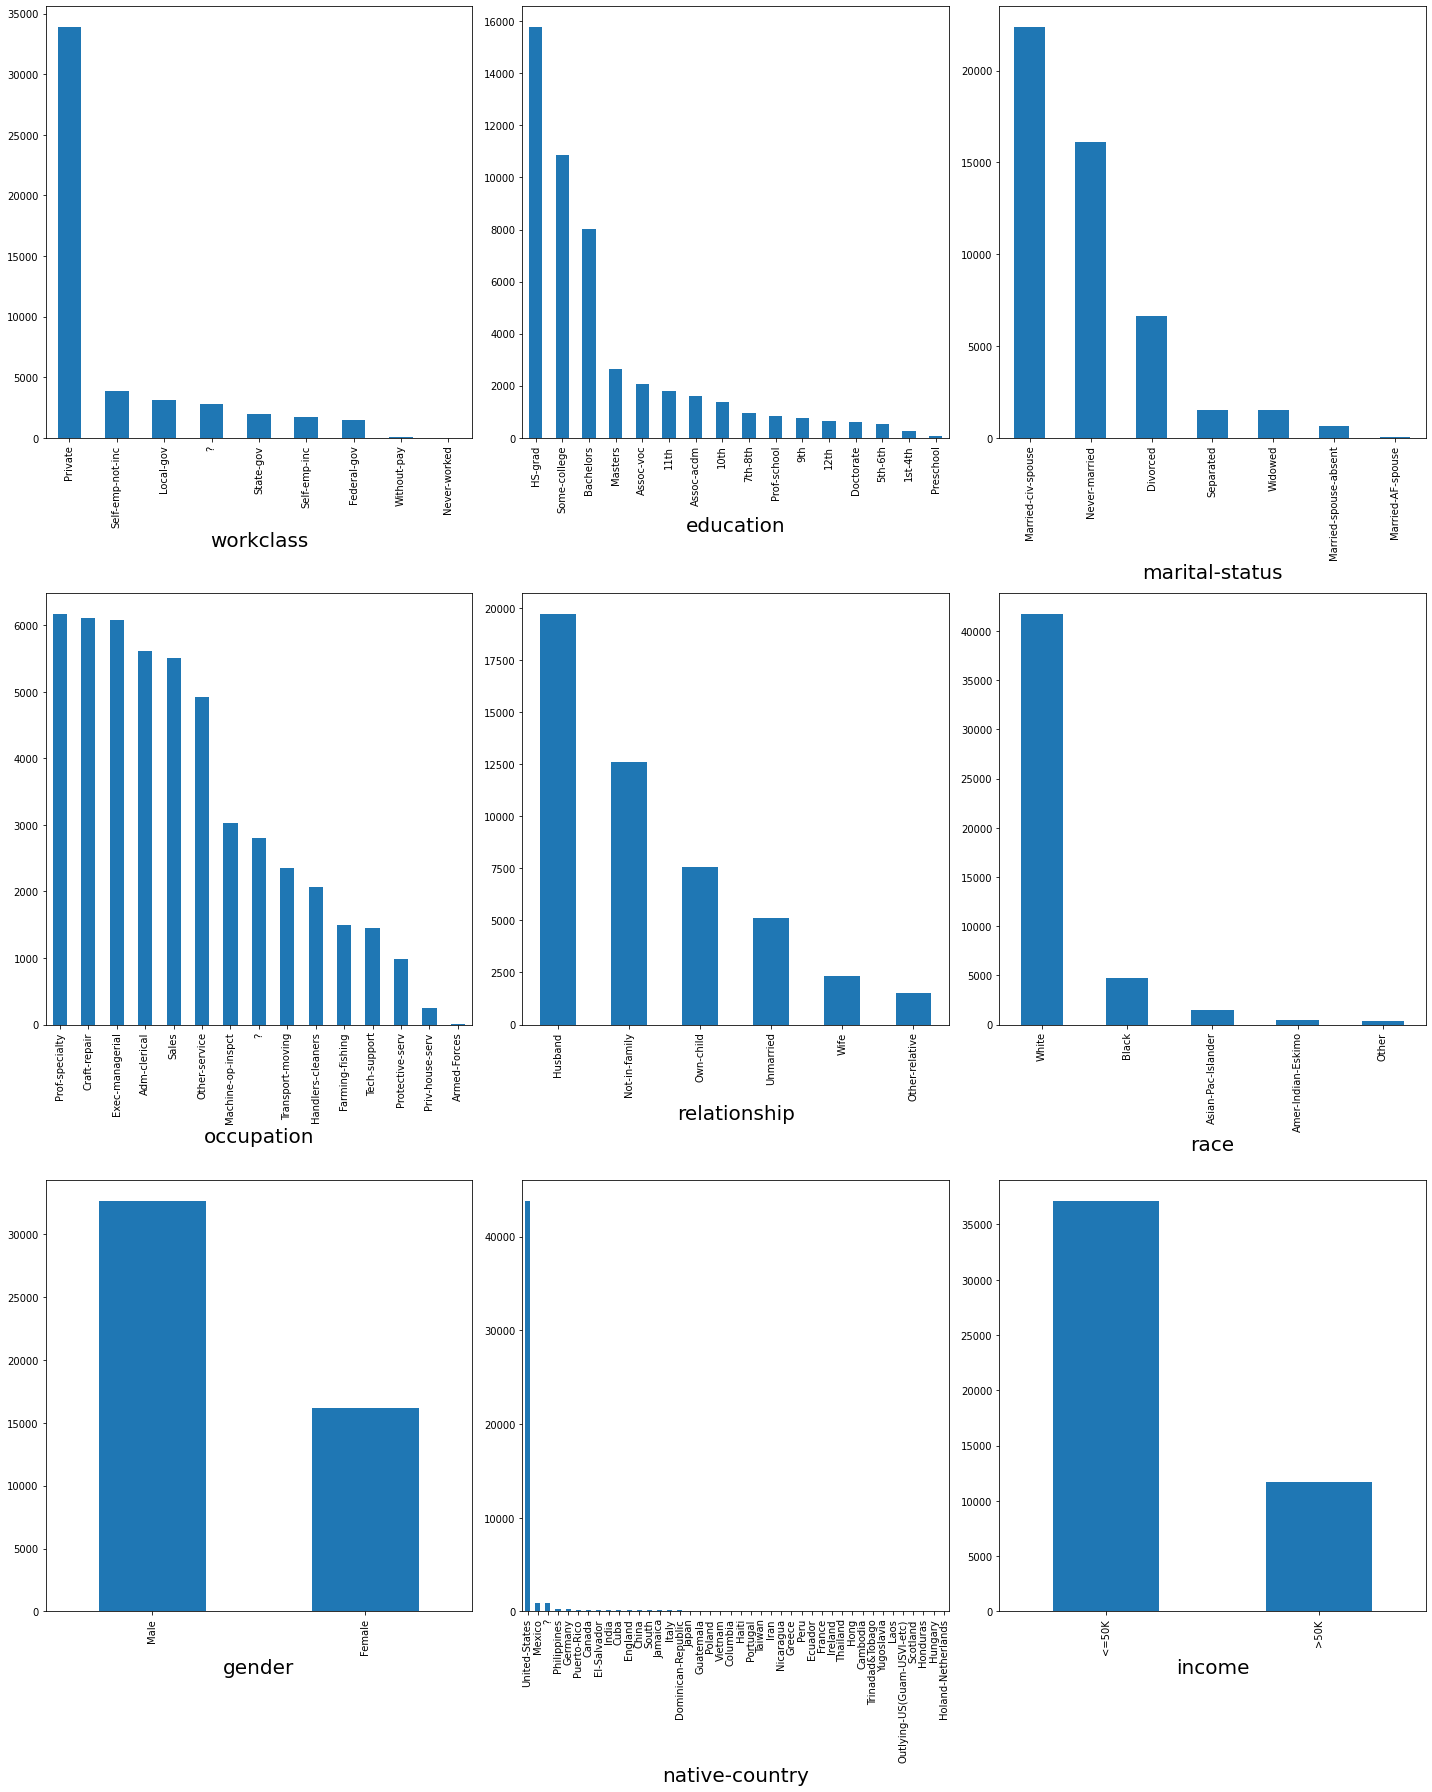

In [ ]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in categorical_data:
    if plotnumber<=16 :
        ax = plt.subplot(3,3,plotnumber)
        categorical_data[column].value_counts().plot(kind='bar')
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.tight_layout()

**Observations:**

* Если мы посмотрим на переменную workclass, то увидим, что 74% людей работают в частном секторе, 26% принадлежат к другим 7 категориям.
* Что касается education, то большинство людей закончили среднюю школу, учились в колледже или, по крайней мере, получили степень магистра.
* Учитывая семейное положение, 50% состоят в браке и 35% никогда не состояли в браке.
* Переменная occupation (рода занятий) равномерно распределяется между разными профессиями.
* Если мы рассмотрим переменную race, 92% - белые, а 8% - принадлежат к 4 другим расам.
* 72% людей в данных - мужчины.
* 96% населения относятся к США, 4% - к остальным странам.
* 25% людей имеют доход выше 50 тысяч и 75% ниже 50 тысяч, это указывает на несбалансированность наших данных


## BI-VARIATE ANALYSIS:

В первом случае двумерного (bivariate) анализа мы построим числовую переменную от переменной income (дохода), чтобы получить больше информации из наших данных.


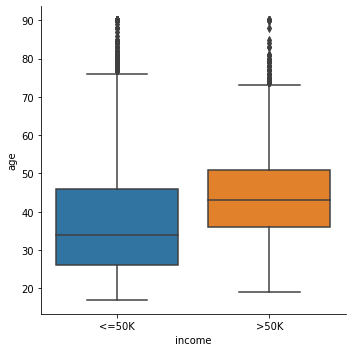

In [ ]:
# Plotting income vs age
sns.catplot(x="income", y= "age", kind="box", data=adi_data_v1)

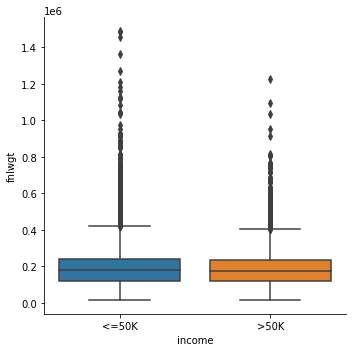

In [ ]:
# Plotting income vs fnlwgt

sns.catplot(x="income", y= "fnlwgt", kind="box", data=adi_data_v1)

**Observations:**

* Несмотря на то, что мы построили график только переменной fnlwgt, переменные capital gain and capital loss имеют схожие характеристики, т.е. они не имеют разницы, выше ли доход 50k или ниже 50k.
* Несмотря на то, что мы нанесли на график только age, переменные educational-num and hours-per-week имеют некоторые вариации в распределении в зависимости от того, превышает ли доход 50 тысяч или меньше 50 тысяч.

**Теперь мы сопоставим категориальные переменные с переменной income, чтобы лучше изучить наши данные.**


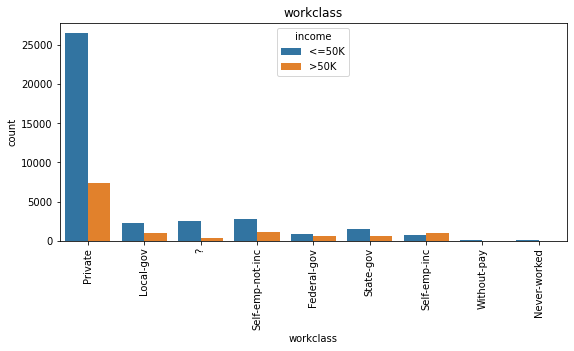

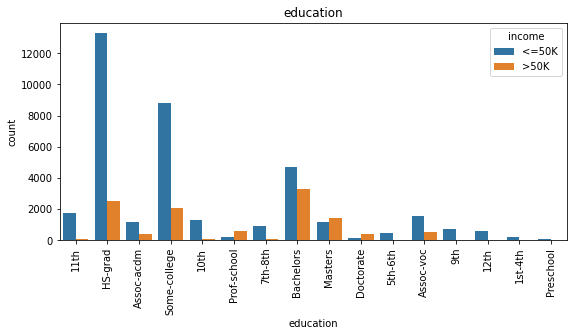

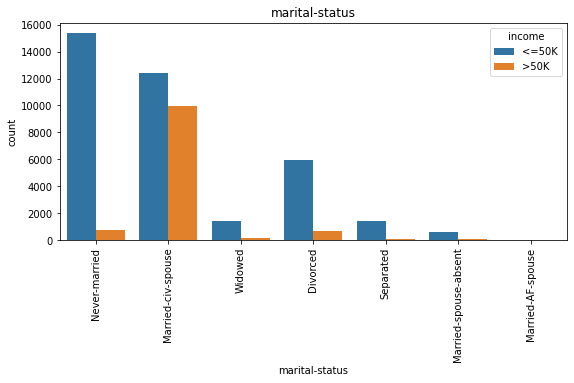

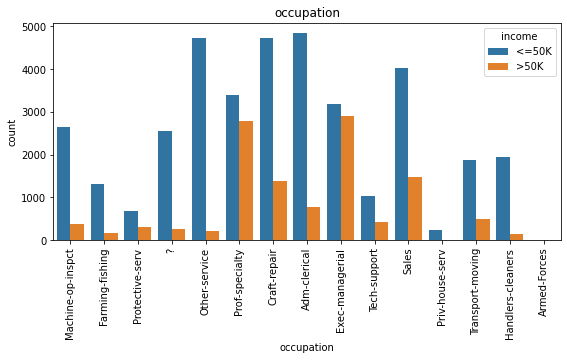

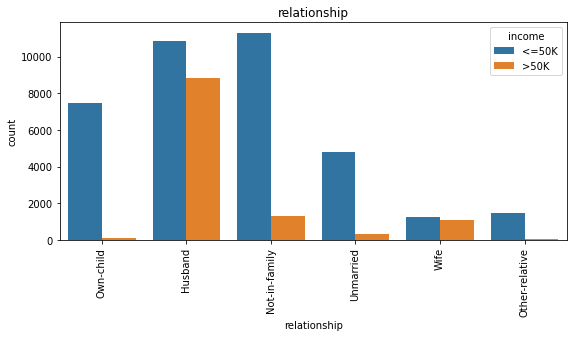

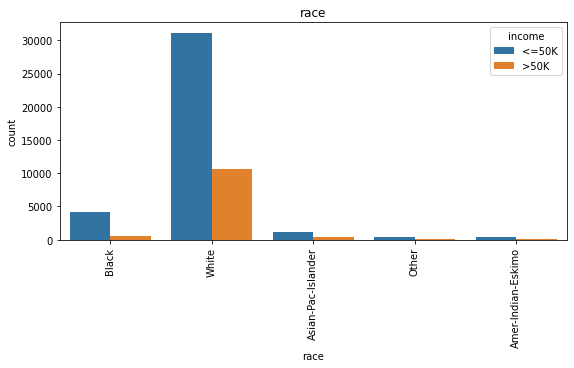

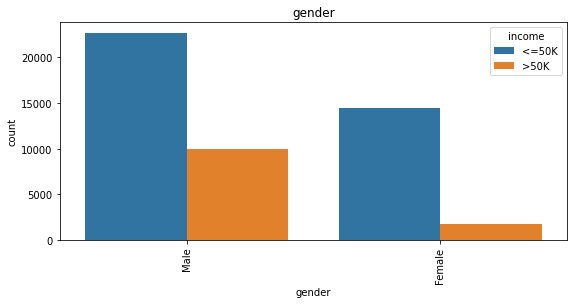

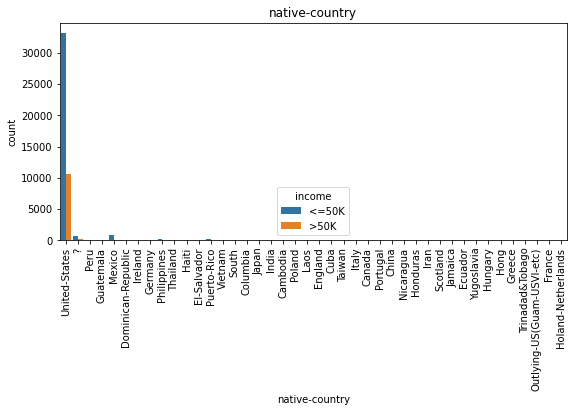

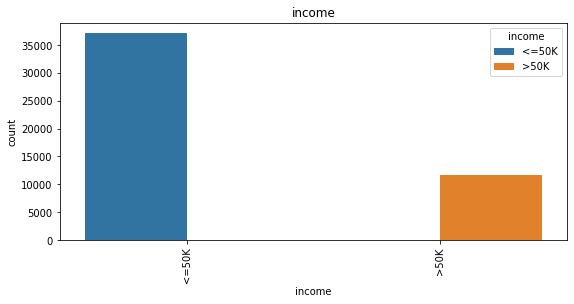

In [ ]:
for column in categorical_data:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.countplot(x=categorical_data[column],hue=categorical_data['income'],data=categorical_data)
    plt.title(column)    
    plt.xticks(rotation=90)

**Observations:**

**Люди с доходом более 50 тысяч:**
* Из workclass, которые privately employed, а также self employed individuals.
* Если рассматривать качество информации, то магистров и бакалавров, а также выпускников средних школ и колледжей.
* По семейному положению - marital status, люди, состоящие в браке (married) и имеющие супруга (have a spouse).
* Лица, занимающие руководящие должности (exec-managerial) или имеющие профессиональную специальность (professional speciality).
* Лица, являющиеся мужьями.
* Белые люди.
* Особи мужского пола.
* Люди, живущие в США.


**Observations from EDA:**
* Некоторые переменные являются высокопрогнозными при классификации того, имеет ли человек доход более 50 тыс. А некоторые переменные менее предиктивные.
* Мы оставим переменные fnlwgt, capital-gain, and capital-loss на основе нашего EDA.
* В основном мы избавимся от переменных с наименьшим потенциалом предсказаний, которые показывают очень малую изменчивость (variance) при создании наших моделей.



**Outlier Treatment:**
Обработка выбросов:
* Мы тщательно проанализировали наши данные и, основываясь на наших наблюдениях, при необходимости будем обрабатывать наши выбросы, учитывая методологию обработки экстремальных выбросов.
* Мы заменим выбросы на `firstquartile-3*IQR` и `thirdquartile+3*IQR`.
* Есть много других методов, с помощью которых мы можем обрабатывать наши выбросы.

На начальных этапах мы проанализировали числовые данные с помощью функции описания. Если мы посмотрим на переменную 'age', она колеблется от 17 до 90, что является идеальным возрастом, который может быть у нормального человека. Кроме того, существует переменная 'educational-num', которая, если внимательно присмотреться, является кодировкой категориальной переменной `education`. Следовательно, мы не будем рассматривать какие-либо выбросы для этих переменных. Кроме того, мы не будем использовать переменные 'fnlwgt', 'capital-loss' and 'capital-gain', поскольку они не показывают достаточной дисперсии. 


Мы подробно рассмотрим переменную 'hours-per-week', чтобы оценить, нужна ли нам обработка выбросов

In [ ]:
# Exploring the hours-per-week variable more.

adi_data_v1['hours-per-week'].describe()

count    45222.000000
mean        40.938017
std         12.007508
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64

**Obsevations:**
* Если мы проверим hours per week, обычно 90 часов в неделю разумно, но есть много случаев, когда люди работали более 90 часов.
* Мы изучим данные более детально для случаев, когда work hours-per-week превышает 90, и решим, нужно ли нам обрабатывать выбросы.


In [ ]:
workhours = adi_data_v1[adi_data_v1['hours-per-week']>= 90]
workhours

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
25,45,Self-emp-not-inc,432824,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7298,0,90,United-States,>50K
384,29,Private,211208,11th,7,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,99,United-States,>50K
723,35,Self-emp-not-inc,28987,9th,5,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,Male,0,0,96,United-States,<=50K
810,46,Private,199378,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,90,United-States,<=50K
901,37,Private,112158,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7688,0,99,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47444,29,Self-emp-not-inc,404998,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,90,United-States,<=50K
47932,28,State-gov,297735,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,90,United-States,<=50K
47962,43,Private,266324,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1902,99,United-States,>50K
47980,43,Self-emp-not-inc,163108,Some-college,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,99,United-States,<=50K


**Observations:**
* Большинство людей, которые работают сверхурочно (work long hours), имеют образование ниже бакалавра (below Bachelor's).
* 65% этих людей имеют доход ниже 50к.
* Таким образом, количество часов работы (work hours) выше 90, мы сохраним их как есть, не считая их выбросами


## IDEAL CASE BASED ON EXTENSIVE EDA:
Идеальным случаем для человека с доходом **выше 50k будет**:

* Возраст около 45 лет.
* Работает около 45 часов в неделю.
* Имеет степень магистра или бакалавра.
* Женат.
* Белый.
* Гражданин США.
* Имеет профессию исполнительного менеджера (exec-managerial) или имеет профессиональную специальность.
* Мужчина.

Это все относительно EDA, надеюсь, вам, ребята, понравилось это путешествие по изучению данных и более глубокому пониманию, мне наверняка было очень весело. Следите за новостями о предстоящих частях (разработка функций, выбор, моделирование и настройка гиперпараметров).
